# Part 1 - SplitLinear
####Description
In this part of the project, we implemented a custom PyTorch module called SplitLinear. The purpose of this module is to split the input tensor into two halves, apply a linear transformation followed by a ReLU activation to each half, and then concatenate the results.

Implementation Details
The SplitLinear class inherits from torch.nn.Module and consists of the following key components:

1. Initialization (__init__ method):

- Takes the number of input features as a parameter.
Initializes a linear layer (nn.Linear) that operates on half the input features.
- Initializes the weights of the linear layer using the Kaiming Normal - initialization, which is suitable for ReLU activations.
2. Forward Pass (forward method):

- Splits the input tensor into two halves.
- Applies the linear transformation and ReLU activation to each half.
- Concatenates the processed halves and returns the result.


This custom module helps in applying transformations to different parts of the input independently, which can be useful in various neural network architectures.

In [ ]:
import torch
import torch.nn as nn

class SplitLinear(nn.Module):
  def __init__(self, in_features):
    """
    Initialize the SplitLinear module.

    Parameters:
    in_features (int): Number of input features.
    """
    super().__init__()
    self.linear = nn.Linear(in_features//2, in_features//2) # use integer divison for tensor dimensions
    self.relu = nn.ReLU()

    # intialize weights for self.linear
    # kaiming_normal_ intializes the weight vector in a nomral distribution N(0, sqrt(2/fan_in))
    # It is recommnded to use when using ReLU activation in the following layer
    # It helps maintaining the variance of the outpout neurons, which helps preventing gradient issues
    nn.init.kaiming_normal_(self.linear.weight, mode='fan_in', nonlinearity='relu')
    if self.linear.bias is not None:
      nn.init.constant_(self.linear.bias,0 )

  def forward(self, input):
    """
    Forward pass for the SplitLinear module.

    Parameters:
    input (Tensor): Input tensor of shape (N, M).

    Returns:
    Tensor: Output tensor after applying split linear layers and ReLU activation.
    """
    # we assume input is a NxM tensor
    N, M = input.shape

    # split input
    split_a = input[:, :M//2]
    split_b = input[:, M//2:]

    # apply a linear layer
    split_a = self.linear(split_a)
    split_b = self.linear(split_b)

    # apply RelU activation
    # alternative here would be to use F.relu() and not define self.relu as a submodule in __init__
    split_a = self.relu(split_a)
    split_b = self.relu(split_b)

    # concat both halves into 1 tensor in size NxM
    y = torch.cat([split_a, split_b], dim=1)

    return y


In my custom layer SplitLinear, there is only one submodule that contains trainable parameters: self.linear, which is a linear layer with weights and biases. The other components within the layer include a ReLU activation and some tensor operations, that for abvious reasons, don't have trainable parameters. Therefore, there is only a need to reset the parameters to the submodule self.linear

ReLU Parameter Intialization:
Since ReLU doesn't get any parameters, there was nothing to intialize there.

# Demonsration
In this code we added prints across the `forward` method of the `SplitLinear` layer. We initilize a SplitLinear layer and feed an input into it, to demonstrate how it works

In [ ]:
import torch
import torch.nn as nn

class SplitLinear(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.linear = nn.Linear(in_features//2, in_features//2) # use integer divison for tensor dimensions
    self.relu = nn.ReLU()

    # intialize weights for self.linear

    # kaiming_normal_ intializes the weight vector in a nomral distribution N(0, sqrt(2/fan_in))
    # It is recommnded to use when using ReLU activation in the following layer
    # It helps maintaining the variance of the outpout neurons, which helps preveting gradient issues
    nn.init.kaiming_normal_(self.linear.weight, mode='fan_in', nonlinearity='relu')
    if self.linear.bias is not None:
      nn.init.constant_(self.linear.bias, 0)

# Initlize forward again with prints
  def forward(self, input):
    # we assume input is a NxM tensor
    N, M = input.shape
    print("-"*50)
    print(f"N={N}\nM={M}")

    # split input
    print("-"*50)
    print("splitting input linear layer...")
    split_a = input[:, :M//2]
    split_b = input[:, M//2:]
    print(f"Split A={split_a}\nSplit B={split_b}")

    # apply a linear layer
    print("-"*50)
    print("apllying linear layer...")
    split_a = self.linear(split_a)
    split_b = self.linear(split_b)
    print(f"Split A={split_a}\nSplit B={split_b}")

    # apply RelU activation
    # alternative here would be to use F.relu() and not define self.relu as a submodule in __init__
    print("-"*50)
    print("apllying ReLU")
    split_a = self.relu(split_a)
    split_b = self.relu(split_b)
    print(f"Split A={split_a}\nSplit B={split_b}")

    # concat both halves into 1 tensor in size NxM
    print("-"*50)
    print("concatinating splitted tensors...")
    y = torch.cat([split_a, split_b], dim=1)
    print(y)
    print("-"*50)

    return y


model = SplitLinear(10)
input_tensor = torch.rand(10, 10)
model(input_tensor)

--------------------------------------------------
N=10
M=10
--------------------------------------------------
splitting input linear layer...
Split A=tensor([[0.3753, 0.6516, 0.3793, 0.6093, 0.1273],
        [0.2676, 0.7417, 0.6147, 0.4680, 0.5737],
        [0.6471, 0.9556, 0.1043, 0.4568, 0.1256],
        [0.4216, 0.8587, 0.4998, 0.3539, 0.8051],
        [0.7561, 0.1529, 0.5263, 0.9525, 0.7818],
        [0.1318, 0.4916, 0.6559, 0.4891, 0.3626],
        [0.3233, 0.4880, 0.0184, 0.6638, 0.2561],
        [0.7097, 0.5717, 0.6006, 0.7629, 0.4689],
        [0.3932, 0.9683, 0.7231, 0.2691, 0.6620],
        [0.6394, 0.7289, 0.3962, 0.5328, 0.3167]])
Split B=tensor([[0.4216, 0.8362, 0.8012, 0.6858, 0.7371],
        [0.1033, 0.9194, 0.5832, 0.4975, 0.7632],
        [0.7893, 0.3078, 0.6372, 0.9144, 0.1580],
        [0.9185, 0.7344, 0.2962, 0.7038, 0.0247],
        [0.6851, 0.3417, 0.2419, 0.0876, 0.2296],
        [0.9593, 0.3896, 0.2878, 0.4183, 0.2028],
        [0.6308, 0.6843, 0.7595, 0.0530

tensor([[0.0000, 0.0000, 0.0840, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6885, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.2773, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3064, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.2811, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0566, 0.0000, 0.0000, 0.0000, 0.0000, 0.1980,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5866,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5836,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<

# Diagram of a Splitlinear Layer
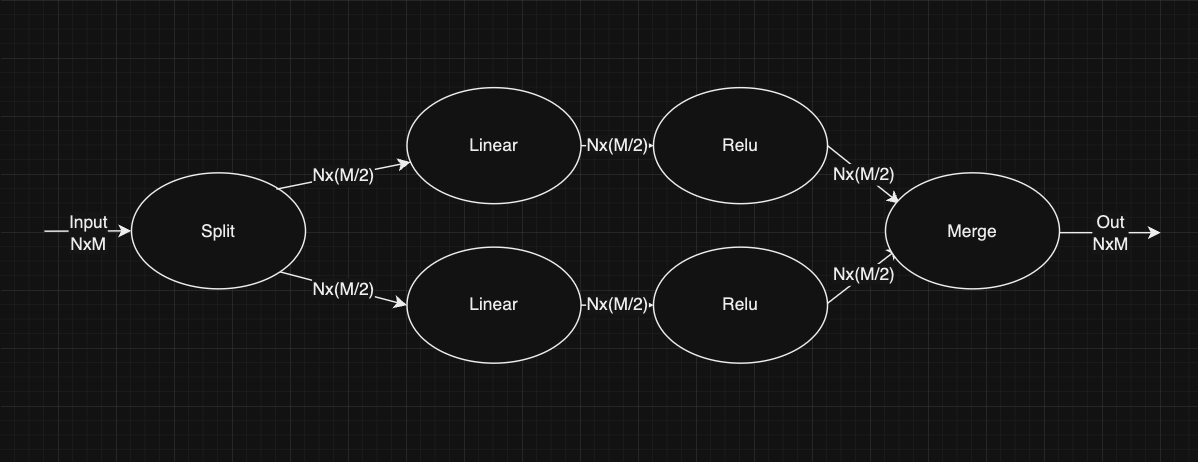

# Parameter Analysis

We'll analyze how many parameters are in SplitLayer and we'll compare it to a standard Linear layer

SplitLinear:
- Input Tensor: N samples and M features
- Split: Recevies an NxM tensor and splits it into Nx(M/2) + Nx(M/2)
- Linear: Recevies an NxM/2 tensor as input and outputs an NxM/2 Tensor. this is done 2 times
- ReLU: Recevies an NxM/2 tensor as input and outputs an NxM/2 Tensor. this is done 2 times
- Merge: Recevies 2 NxM/2 tensors as input and outputs an NxM Tensor.

Since the linear layer have an input of and output of M/2 features, the weight Matrix will be of size M/2xM/2. In addition there will be a bias vector of size M/2.

So in total:
- Weights: (M/2) * (M/2) = M^2/4
- Bias: M/2
- Total: M^2/4 + M/2

In a standard linear layer, which receives M features as input and outputs M features, we will have:
- Weight Matrix of size MxM
- Bias vector of size M

So if we compare Splitlinear to a standard Linear layer:
- SplitLinear: M^2/4 + M/2
- Linear: M^2 + M

# Gradient Analysis

We want to calculate the gradients
$$\frac{\partial C}{\partial W}, \frac{\partial C}{\partial b}$$
and we assume we know the gradient
$$\frac{\partial C}{\partial Y} = [\frac{\partial C}{\partial y_0},\ldots,\frac{\partial C}{\partial y_{M-1}}]^T$$

First let's define all variables:
1. The Input is a matrix $X = [x_0, \ldots, x_{M-1}]$ with dimension NxM. So each element $x_i$ is a column vector with in dimnesion Nx1
2. The splitted inputs are:
  - $X_0=[x_0, \ldots, x_{M/2}$]
  - $X_1=[x_{M/2}, \ldots, x_{M-1}]$
3. The output of the linear layer will be:
  - $Z_0 = W_0X_0 + b_0$
  - $Z_1 = W_1X_1 + b_1$
4. The ReLU output will be:
  - $Y_0 = ReLU(Z_0)$
  - $Y_1 = ReLU(Z_1)$
5. Finally, The merged output will be:
  - $Y = [Y_0, Y_1]$
6. And we have the cost function $C$, let's assume:
  - $\frac{\partial C}{\partial Y} = δ_Y$

After we have denoted all of the variables, our objective will eb to find the gradients of $C$ in repspect to $W_0, W_1, b_0$ and $b_1$

First, we need to split $δ_Y$ into:
  - $δ_{Y0}=δ_Y[:,M/2:]$
  - $δ_{Y1}=δ_Y[:,:M/2]$

Now, we can calculate the gradient of C in respect to $Z_0, Z_1$:
  - $δ_{Z0}=δ_{Y0}*ReLU'(Z_0) = δ_{Y0} * σ(Z_0)$
  - $δ_{Z1}=δ_{Y1}*ReLU'(Z_1) = δ_{Y1} * σ(Z_1)$

Now, we can proceed and calculate the gradient of $Z_0$ and $Z_1$ in respect to $W_0, W_1, b_0, b_1$:
- $\frac{\partial Z_0}{\partial W_0} = X_0 $
- $\frac{\partial Z_1}{\partial W_1} = X_1 $
- $\frac{\partial Z_0}{\partial b_0} = 1 $
- $\frac{\partial Z_1}{\partial b_1} = 1 $


Now, using the chain rule, we can calculate:
- $\frac{\partial C}{\partial W_0} = \frac{\partial C}{\partial δ_{Z0}} \frac{\partial Z_0}{\partial W_0} = X_0^T * δ_{Y0} * σ(Z_0) = X_0^T * δ_{Z0}$
- $\frac{\partial C}{\partial b_0} = \frac{\partial C}{\partial δ_{Z0}} \frac{\partial Z_0}{\partial b_0} = \sum_{i=1}^{N}(δ_{Y0} * σ(Z_0))_i = \sum_{i=1}^{N} (δ_{Z0})_i$

And similarly for $W_1, b_1$:
- $\frac{\partial C}{\partial W_1} = \frac{\partial C}{\partial δ_{Z1}} \frac{\partial Z_1}{\partial W_1} = X_1^T * δ_{Z1}$
- $\frac{\partial C}{\partial b_1} = \frac{\partial C}{\partial δ_{Z1}} \frac{\partial Z_1}{\partial b_1} = \sum_{i=1}^{N} (δ_{Z1})_i$


# Gnerelaizing The Gradient
In a similar way, if we would to split the input into 4 instead of 2, Y itself would be splitted into 4 parts $Y = [Y_0, Y_1, Y_2, Y_3]$

As seen in the prevoius part, splitting Y across it's feature, will not change the calculation of the gradients $\frac{\partial C}{\partial W_i} \frac{\partial C}{\partial b_i}$ for each $ 0≤i≤3$

The gradients will be for each $0≤i≤3$:
- $\frac{\partial C}{\partial W_i} = X_i^T * δ_{Zi} $
- $\frac{\partial C}{\partial b_i} = \sum_{j=1}^{N} (δ_{Zi})_j $


# Part 2 - DropNorm

#### Description
In this part of the project, we implemented a custom normalization technique called DropNorm. The DropNorm module is designed to combine dropout and normalization techniques to enhance the regularization and performance of neural networks.

#### Implementation Details
The `DropNorm` class, similar to `SplitLinear`, inherits from torch.nn.Module and consists of the following components:

1. Initialization (__init__ method):

- Takes parameters for dropout rate and normalization layer (e.g., batch normalization or layer normalization).
- Initializes the dropout and normalization layers based on the provided parameters.
3. Forward Pass (forward method):

- Applies dropout to the input tensor, randomly setting some elements to zero.
- Applies normalization to the result of the dropout, scaling the remaining elements to maintain a consistent distribution.

By combining dropout and normalization, the `DropNorm` module aims to improve the generalization of the neural network while stabilizing the learning process.

In [ ]:
import torch
import torch.nn as nn

class DropNorm(nn.Module):
    def __init__(self, in_features, epsilon = 1e-10):
        """
        Initialize the DropNorm module.

        Parameters:
        in_features (int): Number of input features.
        epsilon (float): Small constant to avoid division by zero in normalization.
        """
        super(DropNorm, self).__init__()
        self.in_features = in_features
        self.gamma = nn.Parameter(torch.ones(in_features))
        self.beta = nn.Parameter(torch.zeros(in_features))

        # initialize droprate to be exclusively 0.5
        self.drop_rate = 0.5

        self.epsilon = epsilon


    def forward(self, input):
        """
        Forward pass for the DropNorm module.

        Parameters:
        input (Tensor): Input tensor of shape (N, *, in_features) where * means any number of additional dimensions.

        Returns:
        Tensor: Output tensor after applying dropout and normalization.
        """
        input_shape = input.shape
        num_features = input_shape[-1]

        # Get 2 randomly chosen groups of feature indices (each group contains half of the features)
        indices = torch.randperm(num_features)
        indices_to_zero = indices[:(num_features // 2)]
        indices_to_normalize = indices[(num_features // 2):]

        if not self.training:
          indices_to_normalize = indices

        # Set half the features to 0 using a mask
        mask = torch.ones_like(input)

        if self.training:
          mask[..., indices_to_zero] = 0


        # Apply mask onto original input tensor
        input_zeroed = input * mask

        # Extract non-zero elements for normalization
        non_zero_elements = input[..., indices_to_normalize]

        # Calculate mean and variance for non-zero elements along the feature dimension for each sample
        mean = torch.mean(non_zero_elements, dim=-1, keepdim=True)
        var = torch.var(non_zero_elements, dim=-1, keepdim=True)
        normalized_input = (non_zero_elements - mean) / torch.sqrt(var + self.epsilon)

        # Create the final output tensor
        output = input_zeroed.clone()
        output[..., indices_to_normalize] = normalized_input

        # Apply gamma and beta only to the normalized elements
        output[..., indices_to_normalize] = self.gamma[indices_to_normalize] * output[..., indices_to_normalize] + self.beta[indices_to_normalize]

        if not self.training:
          output = output * (1 - self.drop_rate)

        return output


'model = DropNorm(4)\ninput = torch.randint(1, 100, (10, 5, 4)).float()\nnormalized_output = model(input)\n\nprint("Input:")\nprint(input)\nprint("\nNormalized Output:")\nprint(normalized_output)'

I've implemented the `forward` method so that, only in the training mode the layer will drop exactly half of the features, and will apply the normalization as described above on the remaining features.
In evaluation mode (or rather, any mode other than training), we are applying the normalization on all of the features, withput dropping any of them.
Because we are not dropping any features in the evaluation mode, there is a scaling that needs to be done, to ensure that the throughput in the layer during evaulation, is similar to the thorughput during training.
Therefore, in evaluation we scale as follows:

```
output = output * (1 - self.drop_rate)
```

Since the `drop_rate` is always 0.5 - we essentially scale down all the weights by 0.5

##  Initilization:

My layer gets 2 hyperparameters:
- `epsilon` which is x by default, this is a constant to prevent division by 0 during the normalization
- `in_features` which is the amount of features in our dataset.

besdies these 2 hyperparameters, we also initilize the learned parameters `gamma` and `beta` which are being used to cumpute the final output of the layer.

The last parameter we intilize is `drop_rate`, which determines the ratio of features our layer is going to drop. it is not a hyperparameter and is set to 0.5 by default.

In [ ]:
# Simulation to test the code
input_tensor = torch.randn(10, 20)  # Example input tensor with batch size of 10 and 20 features
dropnorm = DropNorm(20)

# Set the module to training mode
dropnorm.train()
output_train = dropnorm(input_tensor)

# Set the module to evaluation mode
dropnorm.eval()
output_eval = dropnorm(input_tensor)

output_train, output_eval

'# Simulation to test the code\ninput_tensor = torch.randn(10, 20)  # Example input tensor with batch size of 10 and 20 features\ndropnorm = DropNorm(20)\n\n# Set the module to training mode\ndropnorm.train()\noutput_train = dropnorm(input_tensor)\n\n# Set the module to evaluation mode\ndropnorm.eval()\noutput_eval = dropnorm(input_tensor)\n\noutput_train, output_eval'

# Comparing Networks with Dropout and DropNorm

In this section of the project, we implement and compare two different neural networks to classify images from the FashionMNIST dataset. One network uses standard Dropout layers for regularization, while the other uses DropNorm layers, which are custom normalization layers combining dropout and normalization techniques.

## Steps:
1. Initializing Neural Networks:

- The first network initializes with Dropout layers to regularize the network during training.
- The second network initializes with DropNorm layers to explore the effect of combining dropout with normalization on the network's performance.
2. Training and Evaluation:

- Both networks are trained on the FashionMNIST dataset, which consists of various clothing item images.
- We monitor and record the performance of both networks during training, using metrics such as accuracy and loss.
3. Comparison and Analysis:

- After training, we compare the performance of the two networks.
- The analysis focuses on the differences in their ability to classify the images accurately and their overall training stability.
- By comparing Dropout and DropNorm, we aim to identify any improvements in generalization and robustness offered by the DropNorm layers.


Through this comparison, we seek to understand the impact of different regularization techniques on the performance of neural networks, specifically in the context of image classification tasks.

In [ ]:
# get FashionMNIST

import torch
import torchvision
import torchvision.transforms as transforms

# define device to be GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

trans=torchvision.transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(
 root="/22961", train=True, download=True, transform=trans)
test_set = torchvision.datasets.FashionMNIST(
 root="/22961", train=False, download=True, transform=trans)

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

# Iterators
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)

# get first batch and print shapes
images, labels = next(train_iter)

print(images.shape)
print(labels.shape)


100%|██████████| 26421880/26421880 [00:14<00:00, 1831301.47it/s]


Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 117887.87it/s]


Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 477830.79it/s] 


Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5115441.13it/s]


Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw

torch.Size([256, 1, 28, 28])
torch.Size([256])


# Netwrok 1 - Dropout Layers

Epoch 1/15, Loss: 1.5050516739804694, Accuracy: 0.4852449023977239
Epoch 2/15, Loss: 1.194433441821565, Accuracy: 0.5820700353764473
Epoch 3/15, Loss: 1.041141777004756, Accuracy: 0.6347222221658585
Epoch 4/15, Loss: 0.9445443375313536, Accuracy: 0.6687943261988619
Epoch 5/15, Loss: 0.876426508756394, Accuracy: 0.6932934396824938
Epoch 6/15, Loss: 0.8249372456302034, Accuracy: 0.7115922355060036
Epoch 7/15, Loss: 0.7846624724227245, Accuracy: 0.7260115881458966
Epoch 8/15, Loss: 0.7511769986374581, Accuracy: 0.7379758144946809
Epoch 9/15, Loss: 0.7233274936816935, Accuracy: 0.7479511426413876
Epoch 10/15, Loss: 0.6997129529207311, Accuracy: 0.7564550088821573
Epoch 11/15, Loss: 0.6790566578363312, Accuracy: 0.7637713572042824
Epoch 12/15, Loss: 0.6612059357846882, Accuracy: 0.7700839428402854
Epoch 13/15, Loss: 0.6452079595696126, Accuracy: 0.7756065023316104
Epoch 14/15, Loss: 0.6307099614643399, Accuracy: 0.7805874810211564
Epoch 15/15, Loss: 0.6176732485598706, Accuracy: 0.785127437

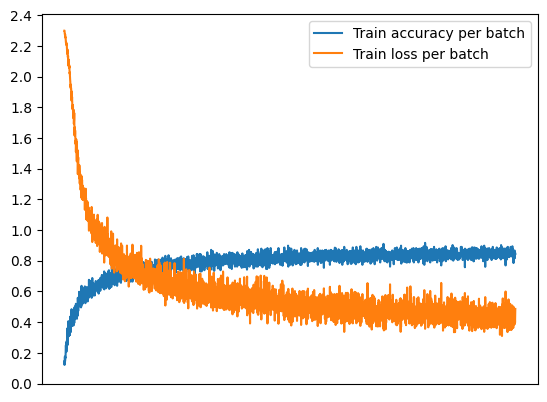

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt


# train function
def train_batch(model, images, labels, CE_loss):
    """
    Train the model on a single batch of images and labels.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    images (Tensor): Batch of input images.
    labels (Tensor): Corresponding labels for the input images.
    CE_loss (function): Cross-entropy loss function.

    Returns:
    float: Accuracy of the model on the current batch.
    float: Loss value of the model on the current batch.
    """
    # set model to training mode
    model.train()
    # move labels & images to gpu
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    preds = model(images)
    loss = CE_loss(preds, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(preds, 1)
    accuracy = (preds == labels).sum() / len(labels)

    return accuracy.item(), loss.item()


def plot_train_acc_and_loss(acc, loss):
  """
  Plot the training accuracy and loss history for each batch.

  Parameters:
  acc (list): List of accuracy values per batch.
  loss (list): List of loss values per batch.
  """
  plt.plot(acc, label='Train accuracy per batch')
  plt.plot(loss, label='Train loss per batch')
  plt.xticks([])
  plt.yticks(torch.arange(0.0,2.5,0.2))
  plt.legend()
  plt.show()


# initialize a deep network
model = nn.Sequential(
    nn.Flatten(), # needed since each batch is 4D
    nn.Linear(784, 256), nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 10)
)

# move model to gpu
model = model.to(device)

epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
CE_loss = nn.CrossEntropyLoss()
num_batches = len(train_dataloader)

batch_accuracies = []
batch_losses = []
for epoch in range(epochs):

  for images, labels in train_dataloader:
    accuracy, loss = train_batch(model, images, labels, CE_loss)
    batch_accuracies.append(accuracy)
    batch_losses.append(loss)
  #accuracies.append(sum(batch_accuracies)/len(batch_accuracies))
  #losses.append(sum(batch_losses)/len(batch_losses))
  print(f"Epoch {epoch+1}/{epochs}, Loss: {sum(batch_losses)/len(batch_losses)}, Accuracy: {sum(batch_accuracies)/len(batch_accuracies)}")


plot_train_acc_and_loss(batch_accuracies, batch_losses)



Mean Test Acc: 0.8509765625
Mean Test Loss: 0.4080815061926842


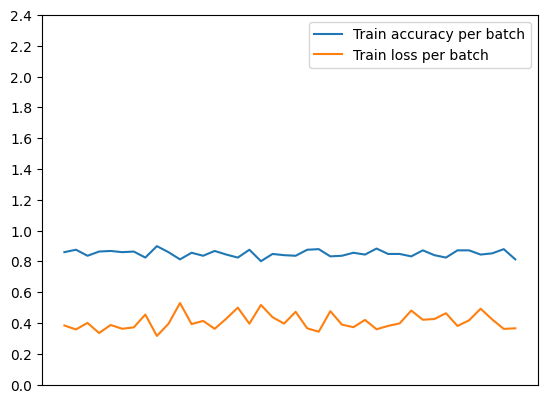

In [ ]:
# test function
def test_batch(model, images, labels, CE_loss):
    """
    Evaluate the model on a single batch of images and labels.

    Parameters:
    model (nn.Module): The neural network model to be evaluated.
    images (Tensor): Batch of input images.
    labels (Tensor): Corresponding labels for the input images.
    CE_loss (function): Cross-entropy loss function.

    Returns:
    float: Accuracy of the model on the current batch.
    float: Loss value of the model on the current batch.
    """
    # move labels & images to gpu
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      optimizer.zero_grad()
      preds = model(images)
      loss = CE_loss(preds, labels)

      _, preds = torch.max(preds, 1)
      accuracy = (preds == labels).sum() / len(labels)

    return accuracy.item(), loss.item()

num_batches = len(test_dataloader)

batch_accuracies = []
batch_losses = []
for images, labels in test_dataloader:
  accuracy, loss = test_batch(model, images, labels, CE_loss)
  batch_accuracies.append(accuracy)
  batch_losses.append(loss)

# Calculate and print mean acc and loss
mean_acc = sum(batch_accuracies) / len(batch_accuracies)
mean_loss = sum(batch_losses) / len(batch_losses)
print(f"Mean Test Acc: {mean_acc}\nMean Test Loss: {mean_loss}")

# Plot acc and loss across batches during testing phase
plot_train_acc_and_loss(batch_accuracies, batch_losses)

# Netwrok 2 - DropNorm Layers

Epoch 1/15, Loss: 1.5170062166579226, Accuracy: 0.5682347074468085
Epoch 2/15, Loss: 1.2353973718399698, Accuracy: 0.6582973182201386
Epoch 3/15, Loss: 1.0696764908783825, Accuracy: 0.7032081117021277
Epoch 4/15, Loss: 0.957768408288347, Accuracy: 0.7311710438829787
Epoch 5/15, Loss: 0.8777202447678181, Accuracy: 0.7504465868625235
Epoch 6/15, Loss: 0.8168567955282563, Accuracy: 0.7645306959219859
Epoch 7/15, Loss: 0.7683426114201184, Accuracy: 0.775796289248307
Epoch 8/15, Loss: 0.7298243322270982, Accuracy: 0.7846478834114177
Epoch 9/15, Loss: 0.6976755603971775, Accuracy: 0.7922663021876739
Epoch 10/15, Loss: 0.6709298297065369, Accuracy: 0.7984297428993469
Epoch 11/15, Loss: 0.6476496356483585, Accuracy: 0.8038981906680581
Epoch 12/15, Loss: 0.6271208098488497, Accuracy: 0.8087262669776348
Epoch 13/15, Loss: 0.6089556654424402, Accuracy: 0.8131708605980131
Epoch 14/15, Loss: 0.5928710725713283, Accuracy: 0.8170565001145684
Epoch 15/15, Loss: 0.5783574382717728, Accuracy: 0.82062832

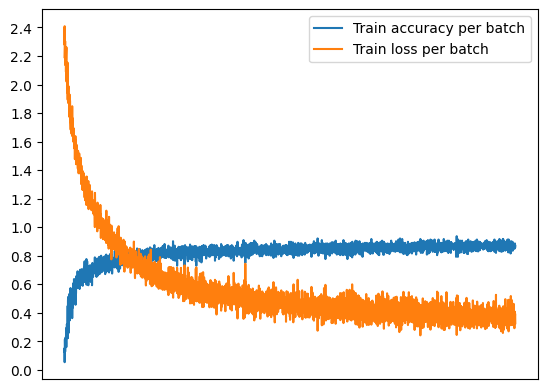

Mean Test Acc: 0.87138671875
Mean Test Loss: 0.37649943828582766


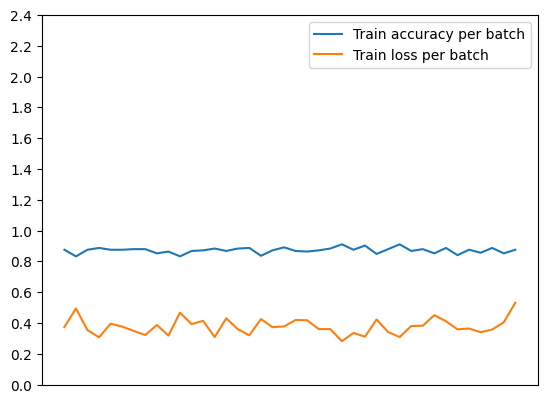

In [ ]:
# initialize a deep network
model = nn.Sequential(
    nn.Flatten(), # needed since each batch is 4D
    nn.Linear(784, 256), nn.ReLU(),
    DropNorm(256),
    nn.Linear(256, 128), nn.ReLU(),
    DropNorm(128),
    nn.Linear(128, 10)
)

# move model to gpu
model = model.to(device)

epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
CE_loss = nn.CrossEntropyLoss()
num_batches = len(train_dataloader)

batch_accuracies = []
batch_losses = []
for epoch in range(epochs):
  for images, labels in train_dataloader:
    accuracy, loss = train_batch(model, images, labels, CE_loss)
    batch_accuracies.append(accuracy)
    batch_losses.append(loss)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {sum(batch_losses)/len(batch_losses)}, Accuracy: {sum(batch_accuracies)/len(batch_accuracies)}")


# Plot train results
plot_train_acc_and_loss(batch_accuracies, batch_losses)


######
#Test#
######

num_batches = len(test_dataloader)

batch_accuracies = []
batch_losses = []
for images, labels in test_dataloader:
  accuracy, loss = test_batch(model, images, labels, CE_loss)
  batch_accuracies.append(accuracy)
  batch_losses.append(loss)

# Calculate and print mean acc and loss
mean_acc = sum(batch_accuracies) / len(batch_accuracies)
mean_loss = sum(batch_losses) / len(batch_losses)
print(f"Mean Test Acc: {mean_acc}\nMean Test Loss: {mean_loss}")

# Plot acc and loss across batches during testing phase
plot_train_acc_and_loss(batch_accuracies, batch_losses)

## Comparison
**Network A (with built-in Dropout):**
- Test Accuracy (Epoch 15): `0.85`
- Test Loss (Epoch 15): `0.4`

**Network B (with DropNorm):**
- Test Accuracy (Epoch 15): `0.87`
- Test Loss (Epoch 15): `0.37`

Overall, both networks gave good results, with the 2nd network (with the DropNorm layers) performing slightly better.

Examining the plots of the accuracy and loss during training of both networks, it can be seen that the training process of Network A (Dropout) was a bit more noisy compared to Network B. It has more fluctuations in the loss curve.

Besides that, the differences were pretty small.

In order to choose which network is better for classifying the Fashion MNIST classification problem, let's dive into the differences:

- Network A: uses DropNorm layers which set exactly half of the neurons to 0 at each batch. Then the layer normalizes the non-zeroed neurons using the variance and mean of these neurons. At the last steps, the layer scales these values using the parameters `beta` and `gamma`.
- Network B: uses a classic dropout, which randomly zeros a portion of the neurons of the networks.

After examining the specifications of each network, I would
choose Network A over Network B for the following reasons:

1. Relative stability during training - Network A demonstrated more stability in training in comparison to Network B. This can be explained by the fact that DropNorm is also normalizing the non-zeroed features, which decreases the variability of the weight distributions across different features, contributing to a more stable training process.
2. Scaling - Network A uses the learnable parameters `beta` and `gamma` in order to scale the features. This adds another layer of control, which can help the network to adapt better during the training process.